## Importación de librerías

In [ ]:
import pandas as pd
import json
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from collections import defaultdict
import random
import joblib
import seaborn as sns

## Configuración de variables globales

In [43]:
with open('setup.json', 'r') as f:
    SETUP_JSON = json.load(f)
FINAL_DATASET = SETUP_JSON['final_dataset']
LEARNING_RATE = SETUP_JSON['learning_rate']
EPOCHS = SETUP_JSON['epochs']

## Cargar el dataset

In [49]:
df = pd.read_parquet(FINAL_DATASET) # Leer dataset final
df.shape

(8247874, 64)

In [6]:
df.head()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,TotLen Fwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,...,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Label Code,Timestamp,Sequence ID
0,443,6,111873906.0,7.0,169.0,46.0,0.0,24.142857,23.197906,46.0,...,155780.0,155551.0,55780941.0,3.933153e+06,58562100.0,52999782.0,Benign,0,0.258819,1
1,3389,6,4363661.0,8.0,1148.0,677.0,0.0,143.500000,228.129662,1173.0,...,0.0,0.0,0.0,0.000000e+00,0.0,0.0,Benign,0,0.258819,1
2,3389,6,1671932.0,8.0,1144.0,677.0,0.0,143.000000,227.969923,1173.0,...,0.0,0.0,0.0,0.000000e+00,0.0,0.0,Benign,0,0.258819,1
3,3389,6,3641507.0,8.0,1148.0,677.0,0.0,143.500000,228.129662,1173.0,...,0.0,0.0,0.0,0.000000e+00,0.0,0.0,Benign,0,0.258819,1
4,80,6,89.0,2.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000e+00,0.0,0.0,Benign,0,0.258819,1


## Invertir el mapeo de etiquetas

In [7]:
# Mapeo de etiquetas
labels = df['Label'].unique()
labels_codes = df['Label Code'].unique()
label_mapping = {int(label_code): label for label_code, label in zip(labels_codes, labels)}
label_mapping

{0: 'Benign',
 1: 'SSH-Bruteforce',
 2: 'FTP-BruteForce',
 3: 'DoS attacks-GoldenEye',
 4: 'DoS attacks-Slowloris',
 5: 'DoS attacks-Hulk',
 6: 'DoS attacks-SlowHTTPTest',
 7: 'DDOS attack-HOIC',
 8: 'DDOS attack-LOIC-UDP',
 9: 'Brute Force -XSS',
 10: 'SQL Injection',
 11: 'Brute Force -Web',
 12: 'Infilteration',
 13: 'Bot'}

## Extracción de secuencias de paquetes

In [17]:
# Obtener una lista de DataFrames de secuencias
sequences = [group_df for _, group_df in df.groupby('Sequence ID')]
print(f"Total de secuencias: {len(sequences)}")

Total de secuencias: 1112159


## Balanceo de clases

Vemos que las clases están desbalanceadas

In [ ]:
sequences_df = pd.DataFrame({
    'Clase': [seq['Label'].iloc[0] for seq in sequences]
})
sequences_df['Clase'].value_counts()

Clase
Benign                      556080
DDOS attack-HOIC            175430
Bot                         130032
DoS attacks-Hulk             90828
FTP-BruteForce               60700
Infilteration                47606
SSH-Bruteforce               34894
DoS attacks-Slowloris         7704
DoS attacks-GoldenEye         7367
DDOS attack-LOIC-UDP           587
Brute Force -Web               576
Brute Force -XSS               220
SQL Injection                   87
DoS attacks-SlowHTTPTest        48
Name: count, dtype: int64

Establecer la mediana como número máximo de secuencias por cada clase

In [21]:
max_sequences = int(sequences_df['Clase'].value_counts().median())
print(f"Número máximo de secuencias: {max_sequences}")

Número máximo de secuencias: 21299


Agrupar secuencias por clase

In [22]:
# Agrupar secuencias por clase
sequences_by_class = defaultdict(list)
for seq in sequences:
    label = seq['Label'].iloc[0]
    sequences_by_class[label].append(seq)

Aplicar submuestreo aleatorio para las clases con más secuencias

In [23]:
sequences = []
for sequence_list in sequences_by_class.values():
    # Submuestreo de clases mayores a la media
    if len(sequence_list) > max_sequences:
        # Aplicar submuestreo a clases mayores
        sequence_list = random.sample(sequence_list, max_sequences)
    sequences.extend(sequence_list)
print(f"Total de secuencias: {len(sequences)}")

Total de secuencias: 165682


Vemos que ahora las clases están más balanceadas

In [ ]:
sequence_df = pd.DataFrame({
    'Clase': [seq['Label'].iloc[0] for seq in sequences],
})
sequence_df['Clase'].value_counts()

Clase
Benign                      21299
SSH-Bruteforce              21299
FTP-BruteForce              21299
DoS attacks-Hulk            21299
Bot                         21299
DDOS attack-HOIC            21299
Infilteration               21299
DoS attacks-Slowloris        7704
DoS attacks-GoldenEye        7367
DDOS attack-LOIC-UDP          587
Brute Force -Web              576
Brute Force -XSS              220
SQL Injection                  87
DoS attacks-SlowHTTPTest       48
Name: count, dtype: int64

## Separación de datos

Establecer una longitud fija para cada secuencia

In [50]:
sequence_df = pd.DataFrame({
    'Longitud': [len(seq) for seq in sequences]
})
sequence_length = int(sequences_df['Longitud'].mean())
print(f"Longitud óptima de secuencia: {sequence_length}")

Longitud óptima de secuencia: 7


Forzamos una longitud fija para secuencia y separamos las secuencias en X e y

In [26]:
X = []
y = []

for seq_df in sequences:  # Iterar sobre las secuencias ya procesadas
    sequence_X_data = seq_df.drop(columns=['Label', 'Label Code', 'Sequence ID']).to_numpy()
    sequence_Y_data = seq_df['Label Code'].iloc[0]

    current_len = sequence_X_data.shape[0]

    if current_len < sequence_length:
        # Padding con ceros al final
        pad_width_rows = sequence_length - current_len
        sequence_X_data = np.pad(sequence_X_data, ((0, pad_width_rows), (0, 0)), mode='constant')
    elif current_len > sequence_length:
        # Recorte al inicio (puedes cambiar a [:sequence_length] si prefieres al inicio)
        sequence_X_data = sequence_X_data[-sequence_length:]

    X.append(sequence_X_data)
    y.append(sequence_Y_data)

X = np.array(X)
y = np.array(y)
X.shape, y.shape

((165682, 7, 61), (165682,))

Escalamiento de características

In [27]:
num_features = X.shape[2]
scaler = StandardScaler()
X_reshaped = X.reshape(-1, num_features)
X_scaled_reshaped = scaler.fit_transform(X_reshaped)
X = X_scaled_reshaped.reshape(len(y), sequence_length, num_features)

## Separar secuencias en entrenamiento, validación y prueba

Separación de datos

In [29]:
# Separar en conjuntos de entrenamiento, validación y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

print(f"Conjunto de entrenamiento: {X_train.shape}, {y_train.shape}")
print(f"Conjunto de validación: {X_val.shape}, {y_val.shape}")
print(f"Conjunto de prueba: {X_test.shape}, {y_test.shape}")

Conjunto de entrenamiento: (106036, 7, 61), (106036,)
Conjunto de validación: (26509, 7, 61), (26509,)
Conjunto de prueba: (33137, 7, 61), (33137,)


Convertir a formato adecuado de entrada para el modelo

In [30]:
# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

## Inicialización del modelo

In [40]:
# Modelo LSTM
class NetFlowLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)         # h_n shape: (1, batch, hidden)
        return self.classifier(h_n[-1])    # usar último estado oculto

model = NetFlowLSTM(input_dim=num_features, hidden_dim=32, output_dim=len(labels))

## Entrenamiento

Dar más peso a las clases de ataques

In [ ]:
# Configurar entrenamiento
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [33]:
# Función de predicción
def predict(model, X_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
    return outputs

In [34]:
# Función de evaluación
def evaluate_model(pred, y_tensor):
    loss = criterion(pred, y_tensor)
    pred = torch.argmax(pred, dim=1)
    acc = (pred == y_tensor).float().mean()
    return loss.item(), acc.item()

Entrenamiento del modelo

In [44]:
val_losses, val_accuracies = [], []

for epoch in range(EPOCHS):
    # Entrenamiento
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    val_pred = predict(model, X_val_tensor) # Predicción
    val_loss, val_acc = evaluate_model(val_pred, y_val_tensor) # Evaluación

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:02d} | Loss: {loss.item():.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}")

Epoch 10 | Loss: 1.5376 | Val Loss: 1.4227 | Val Acc: 0.68
Epoch 20 | Loss: 0.7012 | Val Loss: 0.6348 | Val Acc: 0.82
Epoch 30 | Loss: 0.4078 | Val Loss: 0.3898 | Val Acc: 0.89
Epoch 40 | Loss: 0.2888 | Val Loss: 0.2832 | Val Acc: 0.91
Epoch 50 | Loss: 0.2215 | Val Loss: 0.2203 | Val Acc: 0.93
Epoch 60 | Loss: 0.1863 | Val Loss: 0.1879 | Val Acc: 0.93
Epoch 70 | Loss: 0.1681 | Val Loss: 0.1687 | Val Acc: 0.94
Epoch 80 | Loss: 0.1538 | Val Loss: 0.1535 | Val Acc: 0.94
Epoch 90 | Loss: 0.1435 | Val Loss: 0.1432 | Val Acc: 0.94
Epoch 100 | Loss: 0.1375 | Val Loss: 0.1376 | Val Acc: 0.94
Epoch 110 | Loss: 0.1307 | Val Loss: 0.1316 | Val Acc: 0.95
Epoch 120 | Loss: 0.1300 | Val Loss: 0.1315 | Val Acc: 0.95
Epoch 130 | Loss: 0.1248 | Val Loss: 0.1254 | Val Acc: 0.95
Epoch 140 | Loss: 0.1196 | Val Loss: 0.1210 | Val Acc: 0.95
Epoch 150 | Loss: 0.1173 | Val Loss: 0.1200 | Val Acc: 0.95
Epoch 160 | Loss: 0.1313 | Val Loss: 0.1331 | Val Acc: 0.95
Epoch 170 | Loss: 0.1212 | Val Loss: 0.1233 | Val

## Gráfica del entrenamiento

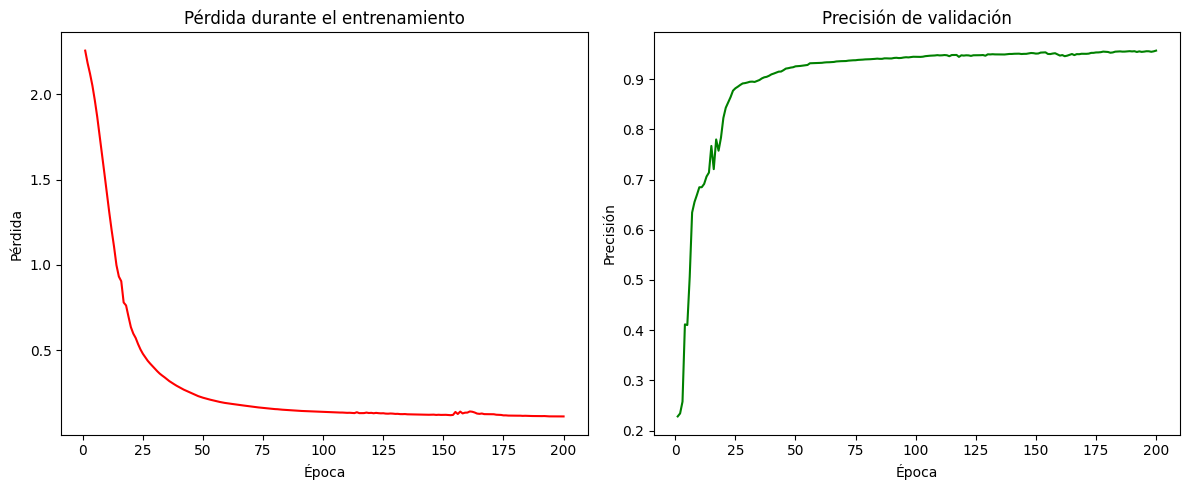

In [45]:
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 5))

# Pérdidas
plt.subplot(1, 2, 1)
plt.plot(epochs_range, val_losses, color='red')
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.title("Pérdida durante el entrenamiento")

# Precisión
plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_accuracies, color='green')
plt.xlabel("Época")
plt.ylabel("Precisión")
plt.title("Precisión de validación")

plt.tight_layout()
plt.show()

## Evaluación

Evaluación en el conjunto de test

In [46]:
test_pred = predict(model, X_test_tensor) # Predicción
test_loss, test_acc = evaluate_model(test_pred, y_test_tensor) # Evaluación

print(f"\n🔍 Evaluación final en test:")
print(f"Pérdida en test: {test_loss:.4f}")
print(f"Precisión en test: {test_acc:.2f}")


🔍 Evaluación final en test:
Pérdida en test: 0.1137
Precisión en test: 0.95


Matriz de confusión de la predicción obtenida

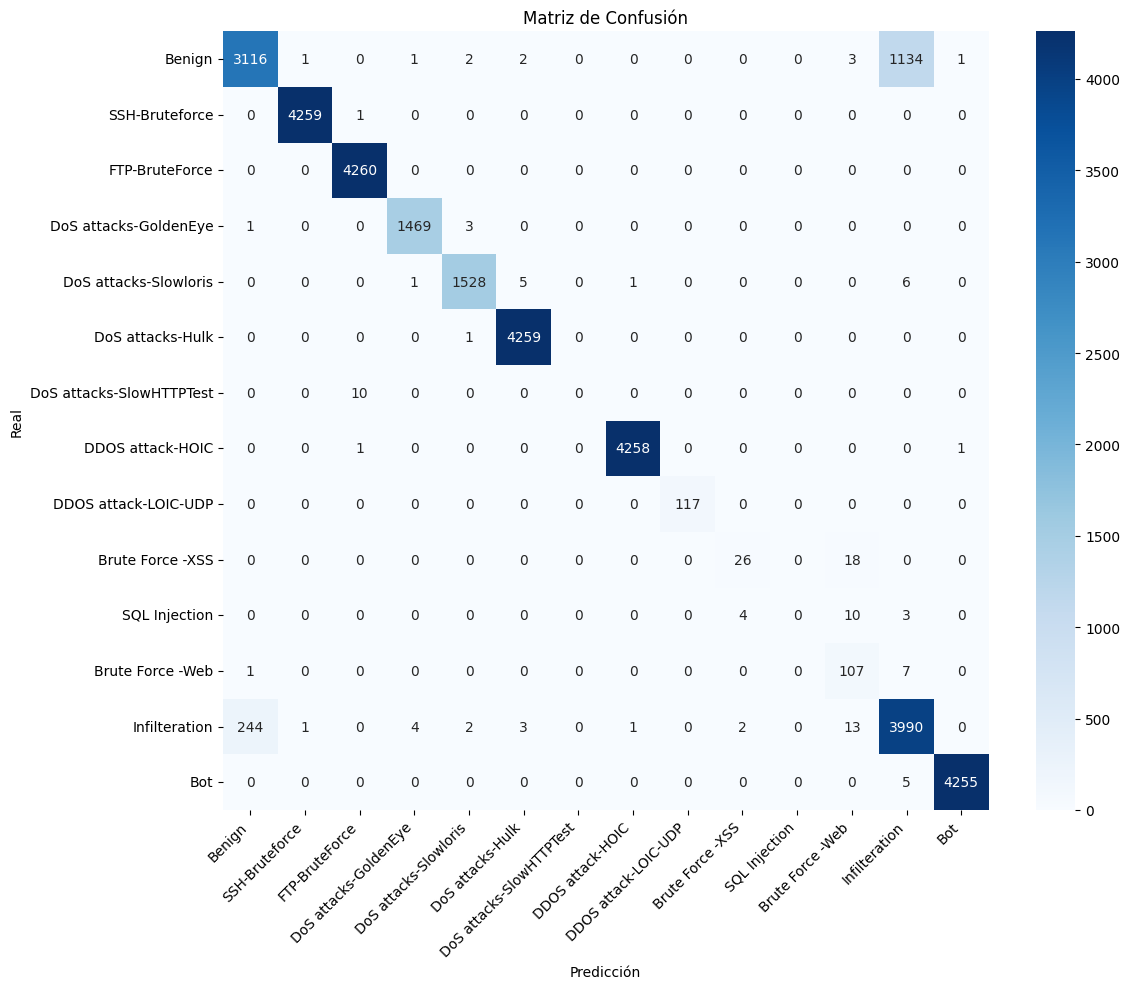

In [47]:
# 1. Obtener predicciones desde logits o probabilidades
pred = torch.argmax(test_pred, dim=1).cpu().numpy()

# 2. Asegurar que y_test esté en numpy
y_test = y_test.cpu().numpy() if isinstance(y_test, torch.Tensor) else y_test

# 3. Mapear a nombres legibles (asegúrate que label_mapping sea dict {int: str})
pred_names = np.array([label_mapping[y] for y in pred])
y_test_names = np.array([label_mapping[y] for y in y_test])

# 4. Obtener lista de etiquetas ordenadas
labels = list(label_mapping.values())

# 5. Matriz de confusión
cm = confusion_matrix(y_test_names, pred_names, labels=labels)

# 6. Visualización con seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Evaluación por clase

Evaluación por cada clase en el conjunto de test

In [48]:
# Diccionario para almacenar los datos de test por clase
test_data_by_class = {}

# Almacenar los datos de test por clase
for class_label in torch.unique(y_test_tensor):
    mask = y_test_tensor == class_label
    class_name = label_mapping[class_label.item()]
    test_data_by_class[class_name] = {
        'X': X_test_tensor[mask],
        'y': y_test_tensor[mask]
    }

for cls, data in test_data_by_class.items():
    X_cls, y_cls = data['X'], data['y']
    cls_pred = predict(model, X_cls) # Predicción
    cls_loss, cls_acc = evaluate_model(cls_pred, y_cls) # Evaluación
    print(f"Clase: {cls}, Pérdida: {cls_loss:.4f}, Precisión: {cls_acc:.2f}")

Clase: Benign, Pérdida: 0.4352, Precisión: 0.73
Clase: SSH-Bruteforce, Pérdida: 0.0050, Precisión: 1.00
Clase: FTP-BruteForce, Pérdida: 0.0034, Precisión: 1.00
Clase: DoS attacks-GoldenEye, Pérdida: 0.0261, Precisión: 1.00
Clase: DoS attacks-Slowloris, Pérdida: 0.0678, Precisión: 0.99
Clase: DoS attacks-Hulk, Pérdida: 0.0048, Precisión: 1.00
Clase: DoS attacks-SlowHTTPTest, Pérdida: 4.8334, Precisión: 0.00
Clase: DDOS attack-HOIC, Pérdida: 0.0027, Precisión: 1.00
Clase: DDOS attack-LOIC-UDP, Pérdida: 0.0811, Precisión: 1.00
Clase: Brute Force -XSS, Pérdida: 0.8011, Precisión: 0.59
Clase: SQL Injection, Pérdida: 3.4230, Precisión: 0.00
Clase: Brute Force -Web, Pérdida: 0.7001, Precisión: 0.93
Clase: Infilteration, Pérdida: 0.3365, Precisión: 0.94
Clase: Bot, Pérdida: 0.0085, Precisión: 1.00


## Despliegue

In [97]:
# --- Guardar el Diccionario de Estado del Modelo ---
model_save_path = 'flask-csv-api\\netflow_lstm_model_state_dict.pth'
torch.save(model.state_dict(), model_save_path)

# --- Guardar el Escalador ---
scaler_save_path = 'flask-csv-api\\scaler.joblib'
joblib.dump(scaler, scaler_save_path)

# --- Guardar el Mapeo de Etiquetas ---
label_mapping_save_path = 'flask-csv-api\\label_mapping.json'
with open(label_mapping_save_path, 'w') as f:
    json.dump(label_mapping, f, indent=4)

# --- Guardar Parámetros del Modelo (sequence_length, num_features, feature_columns) ---
feature_columns = [col for col in sequences[0].columns if col not in ['Label', 'Label Code', 'Sequence ID']]
sequence_length = X_train_tensor[0].shape[0]
print(feature_columns)
model_params = {
    'sequence_length': sequence_length,
    'num_features': num_features,
    'hidden_dim': model.lstm.hidden_size, # Obtener hidden_dim de la instancia del modelo
    'output_dim': model.classifier.out_features, # Obtener output_dim de la instancia del modelo
    'feature_columns': feature_columns # Guardar el orden de las columnas de características
}

# --- Exportar los Parámetros del Modelo ---
model_params_save_path = 'flask-csv-api\\model_params.json'
with open(model_params_save_path, 'w') as f:
    json.dump(model_params, f, indent=4)

['Timestamp', 'Dst Port', 'Protocol', 'Tot Fwd Pkts', 'TotLen Fwd Pkts', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean', 'Flow Pkts/s', 'Bwd IAT Mean', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd Header Len', 'Fwd Pkts/s', 'Bwd Pkts/s', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'Pkt Size Avg', 'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Init Fwd Win Byts', 'Fwd Act Data Pkts', 'Fwd Seg Size Min']


In [98]:
print("\n--- Artefactos para producción: ---")
print(f"1. Diccionario de estado del modelo: {model_save_path}")
print(f"2. Escalador: {scaler_save_path}")
print(f"3. Mapeo de etiquetas: {label_mapping_save_path}")
print(f"4. Parámetros del modelo (incluyendo orden de características): {model_params_save_path}")
print(f"5. La definición de la clase NetFlowLSTM (necesaria para reconstruir el modelo).")


--- Artefactos para producción: ---
1. Diccionario de estado del modelo: flask-csv-api\netflow_lstm_model_state_dict.pth
2. Escalador: flask-csv-api\scaler.joblib
3. Mapeo de etiquetas: flask-csv-api\label_mapping.json
4. Parámetros del modelo (incluyendo orden de características): flask-csv-api\model_params.json
5. La definición de la clase NetFlowLSTM (necesaria para reconstruir el modelo).


In [88]:
df.head()

,Timestamp,Dst Port,Protocol,Tot Fwd Pkts,TotLen Fwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Mean,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,...,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Init Fwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Label,Label Code,Sequence ID
0,0.866025,0,0,3.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,3.0,0.0,-1.0,0.0,0.0,Benign,0,1
1,0.866025,0,0,3.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,3.0,0.0,-1.0,0.0,0.0,Benign,0,1
2,0.866025,0,0,3.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,3.0,0.0,-1.0,0.0,0.0,Benign,0,1
3,0.866025,22,6,15.0,1239.0,744.0,82.600000,976.0,0.0,227.300000,...,82.600000,227.300000,15.0,1239.0,65535.0,6.0,32.0,Benign,0,1
4,0.866025,22,6,14.0,1143.0,744.0,81.642857,976.0,0.0,200.818182,...,81.642857,200.818182,14.0,1143.0,5808.0,6.0,32.0,Benign,0,1
